In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
from util import add_angles, angle_between, angled_vector

In [2]:
def get_rotation_matrix(angle):
    c = np.cos(angle)
    s = np.sin(angle)
    R = np.array([c, -s, s, c]).reshape(2,2)
    return R

In [3]:
R = get_rotation_matrix(np.deg2rad(270))
R @ np.array([1,0])

array([ -1.83697020e-16,  -1.00000000e+00])

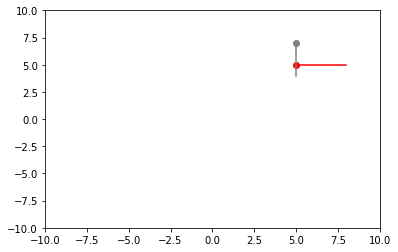

In [4]:
def plot_grid(p1, p2, traj1, traj2):
    fig, ax = plt.subplots()
    ax.scatter(p1[0], p1[1], c='r')
    ax.scatter(p2[0], p2[1], c='gray')

    ax.plot([p1[0], p1[0] + traj1[0]], [p1[1], p1[1] + traj1[1]], c='r')
    ax.plot([p2[0], p2[0] + traj2[0]], [p2[1], p2[1] + traj2[1]], c='gray')

    ax.set_xbound(-10, 10)
    ax.set_ybound(-10, 10)
    

pos1, pos2 = np.array([5,5]), np.array([5,7])
ang1, ang2 = np.deg2rad([0, -90])
traj1, traj2 = angled_vector(ang1) * 3, angled_vector(ang2) * 3

plot_grid(pos1, pos2, traj1, traj2)

-90.0

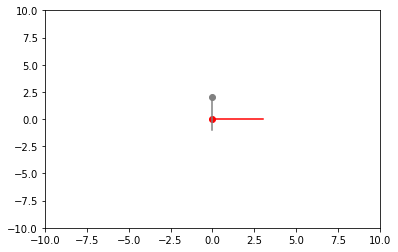

In [5]:
# RF
# 1. Rotate coord system.
R = get_rotation_matrix(-ang1)
pos1_rot = R @ pos1.reshape(2,1)
pos2_rot = R @ pos2.reshape(2,1)
traj1_rot = R @ traj1
traj2_rot = R @ traj2
# 2. Set p1 at center (0,0) and adjust other
pos2_rot -= pos1_rot
pos1_rot = np.array([0.0, 0.0])
ang1_rot = 0.0
ang2_rot = ang2 - ang1
# 3. Plot
plot_grid(pos1_rot, pos2_rot, traj1_rot, traj2_rot)

np.rad2deg(ang2_rot)

In [6]:
df_kicks_tr = pd.read_csv('../../data/processed/kicks_guy_train.csv')

In [7]:
from itertools import product
df = df_kicks_tr.copy()

# Group columns by kick (dt=0,1,..)
max_dt = df['dt'].max() + 1
assert(len(df) % max_dt == 0)
num_kicks = len(df)//max_dt
groups = np.repeat(np.arange(0, num_kicks), max_dt)
df['group'] = pd.Series(groups, index=df.index)

# Consider only a small subsample of data here.
# Drop all kicks where one timestep is too close to the wall
wall_dist_col = [f'wall_distance{i}_f{id}' for i, id in product(range(0,4), range(0,2))]
min_wall_dist = df[wall_dist_col].min(axis=1)

# TODO: Maybe only drop when dt=0 is not close to wall.
groups_to_drop = np.unique(df.loc[min_wall_dist < 7,'group'])
to_drop = df['group'].isin(groups_to_drop)
df =df.loc[~to_drop,:]
df = df[['dt', 'heading_change', 'x_f0', 'y_f0', 'x_f1', 'y_f1', 'angle_f0', 'angle_f1']]

# Add angle of fish zero at start of kick
is_kick = df['dt'] == 0
rotating_angle = np.repeat(df.loc[is_kick, 'angle_f0'].values, max_dt)
df.loc[:,'rotation_angle'] = pd.Series(rotating_angle, index=df.index)

In [8]:
# Compute relative coords/angles
def transform_row(row):
    rotation_angle = row['rotation_angle']
    rotation_matrix = get_rotation_matrix(-rotation_angle)
    
    pos_f0 = np.array([row['x_f0'], row['y_f0']])
    pos_f1 = np.array([row['x_f1'], row['y_f1']])
    
    # Rotate both fish s.t. fish 0 has angle 0
    pos_f0 = (rotation_matrix @ pos_f0.reshape(2,1))
    pos_f1 = (rotation_matrix @ pos_f1.reshape(2,1))
    
    # Put fish zero at (0,0) in coord system
    pos_f1 = (pos_f1 - pos_f0).reshape(2)
    pos_f0 = np.array([0,0])

    angle_f1 = row['angle_f1'] - rotation_angle
    
    row = pd.Series(data=[row['dt'], row['heading_change'], pos_f1[0], pos_f1[1], angle_f1],
                    index=['dt', 'heading_change', 'x_f1', 'y_f1', 'angle_f1'])
    return row

df = df.apply(transform_row, axis=1)

In [9]:
def get_bins(df, num_bins=5):
    # Build symmetric receptive field.
    rf_size = max(df['x_f1'].abs().max(), df['y_f1'].abs().max())
    
    # RF has size rf_size x rf_size, each direction divided by num_bins
    # Should be of form 2n-1 (symmetric in pos/neg. direction, centered at (0,0))
    assert(((num_bins-1) % 2) == 0)
    
    b = np.linspace(rf_size, 0, num=num_bins//2, endpoint=False)
    #b = np.array([rf_size/(i+1) for i in range(num_bins//2)])
    bins = np.hstack((-b,[0], b[::-1]))
    
    return bins
get_bins(df,11)

array([-7.97543544, -6.38034835, -4.78526127, -3.19017418, -1.59508709,
        0.        ,  1.59508709,  3.19017418,  4.78526127,  6.38034835,
        7.97543544])

In [10]:
bins = get_bins(df, 5)
def get_bin(df, bins):
    bin_x = np.digitize(df['x_f1'], bins=bins) - 1
    bin_y = np.digitize(df['y_f1'], bins=bins) - 1
    return (bin_x*len(bins)) + bin_y

df['bin'] = pd.Series(get_bin(df, bins), index=df.index)
df.head()

,dt,heading_change,x_f1,y_f1,angle_f1,bin
6,0.0,-0.030674,-0.515097,2.755624,-0.355654,7
7,1.0,-0.030674,-0.549838,2.773611,-0.381885,7
8,2.0,-0.030674,-0.564402,2.781590,-0.399634,7
9,0.0,1.339604,-1.776512,2.700479,-0.402597,7
10,1.0,1.339604,-1.765986,2.700414,-0.424818,7


In [11]:
import sklearn.preprocessing as pre

def get_Xy(df):
    cur_df = df

    # Scale angle:
    angle_scaler = pre.StandardScaler()
    angle_scaled = angle_scaler.fit_transform(X=cur_df['angle_f1'].values.reshape(-1,1)).reshape(-1)

    # Now we need to one-hot enccode our data.
    # We need one column per variable and bin

    # Indicator for position
    position_one_hot = pd.get_dummies(cur_df['bin'])
    # Mean of angle for bin
    angle_one_hot = pd.get_dummies(cur_df['bin']).values * angle_scaled[:, None]

    X = np.concatenate((position_one_hot, angle_one_hot), axis=1)
    y = cur_df['heading_change'].values
    return X, y

X_np, y_np = get_Xy(df.loc[df['dt']==0])
X_np.shape

(3266, 30)

In [12]:
import torch
from torch.autograd import Variable
from torch.utils import data
from torch import nn
from torch import optim

X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).float()
train = data.TensorDataset(data_tensor=X, target_tensor=y)
train_data = data.DataLoader(train, batch_size=512, pin_memory=True)
type(X), type(y)

(torch.FloatTensor, torch.FloatTensor)

In [13]:
class LinearRF(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.linear = nn.Linear(in_features=n_features, out_features=1, bias=True)     
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.fill_(0.0)
        
    def forward(self, x):
        return self.linear(x)

class MlpRF(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        n_hidden=512
        linear_out = nn.Linear(in_features=n_hidden, out_features=1, bias=True)  
        self.layers = nn.Sequential(*[
            nn.Linear(in_features=n_features, out_features=n_hidden),
            nn.Dropout(p=0.1),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=n_hidden, out_features=n_hidden),
            nn.Dropout(p=0.1),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=n_hidden, out_features=n_hidden),
            nn.Dropout(p=0.1),
            nn.ReLU(inplace=True),
            linear_out])
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.fill_(0.05)

        
    def forward(self, x):
        return self.layers(x)    
    
model = LinearRF(n_features=X.shape[1]).cuda()
#model = MlpRF(n_features=X.shape[1]).cuda()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4, lr=1e-2)
lbfgs = optim.LBFGS(model.parameters(), lr=1)

for epoch in range(20):
    def closure():
            lbfgs.zero_grad()
            y_hat = model(Variable(X).cuda()).squeeze()
            output = torch.sum((y_hat - Variable(y).cuda())**2)
            output.backward()
            return output
    lbfgs.step(closure)
    y_hat = model(Variable(X).cuda()).squeeze()
    loss = torch.sum((y_hat - Variable(y).cuda())**2)
    print(loss.data[0])

1101.19384765625
1099.289794921875
1099.2803955078125
1099.2803955078125
1099.2803955078125
1099.2803955078125
1099.2802734375
1099.2802734375
1099.2802734375
1099.2802734375
1099.2802734375
1099.2803955078125
1099.2802734375
1099.2803955078125
1099.2803955078125
1099.2803955078125
1099.2803955078125
1099.2802734375
1099.2802734375
1099.2802734375


In [14]:
num_epochs = 10#00
for epoch in range(num_epochs):
    cur_loss = 0.0
    for batch in train_data:
        x_batch, y_batch = [Variable(b.float().cuda()) for b in batch]

        optimizer.zero_grad()
        
        y_hat = model(x_batch).squeeze()
        loss = torch.sum((y_hat - y_batch)**2)
        loss.backward()
        
        optimizer.step(closure)
        
        cur_loss += loss.data[0]

    if True or (epoch % 100) == 0:
        print(cur_loss/len(X))

0.3372983821534848
0.3365517340039302
0.33649734478382265
0.3367258423468268
0.3364610058795581
0.33667575721717363
0.3365474918176262
0.3365653167089216
0.33661732086723595
0.33656925638249074


In [15]:
import sklearn.linear_model as lm
linear = lm.ElasticNetCV(l1_ratio=0.95,normalize=False, max_iter=5000)
linear = linear.fit(X_np,y)

In [16]:
linear.coef_, linear.intercept_

(array([ 0.        , -0.02758895,  0.        , -0.84671738, -0.27356123,
         0.16094931,  0.58230999,  0.        , -0.39491813, -0.1708297 ,
         0.0857409 ,  0.32692682,  0.        , -0.        ,  0.        ,
        -0.        ,  0.        ,  0.49997176,  0.        ,  0.02231846,
        -0.03849519,  0.        ,  0.        ,  0.        , -0.00474375,
         0.        ,  0.        , -0.        , -0.        ,  0.        ]),
 0.052198389227363064)

In [17]:
linear.score(X_np, y)

0.12356694751305665

In [18]:
model.linear.weight, model.linear.bias

(Parameter containing:
 
 Columns 0 to 9 
  0.6199 -0.2795 -0.0304 -1.2222 -0.3381  0.1069  0.8643  0.9734 -0.7228 -0.2356
 
 Columns 10 to 19 
  0.0308  0.4216 -0.0166 -0.1084  0.2110 -0.2196  0.1995  0.5782 -0.0407  0.0260
 
 Columns 20 to 29 
 -0.0443  0.1166  0.8519  0.0332 -0.0093  0.0030  0.0230 -0.2301 -0.0131  0.0266
 [torch.cuda.FloatTensor of size 1x30 (GPU 0)], Parameter containing:
  0.1122
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [19]:
from sklearn import metrics
enet_r2 = metrics.r2_score(y_true=y_np, y_pred=linear.predict(X_np), )

nn_yhat = model(Variable(X.cuda())).cpu().data.numpy()
nn_r2 = metrics.r2_score(y_true=y_np, y_pred=nn_yhat)

mean_yhat = np.ones_like(y_np) * y_np.mean()
mean_r2 = metrics.r2_score(y_true=y_np, y_pred=mean_yhat)

enet_r2, nn_r2, mean_r2

(0.12356694890965003, 0.13116815614876332, 0.0)

In [20]:
from scipy import stats
stats.spearmanr(y_np, nn_yhat), stats.spearmanr(y_np, linear.predict(X_np))

(SpearmanrResult(correlation=0.338365159697814, pvalue=2.7138213229146633e-88),
 SpearmanrResult(correlation=0.32819447396863444, pvalue=7.1180147776374648e-83))

In [21]:
stats.pearsonr(y_np, linear.predict(X_np))

(0.35301354364438164, 1.8296134309037171e-96)

In [22]:
np.rad2deg(y_np[100:150])

array([  -0.42676383, -109.73684174,  -51.23251491,  -21.40314909,
        -28.09663205,   34.15897134,   -2.79358837,  -27.63686465,
         27.55447893,  -35.30208545,   59.90759599,   50.22023994,
         -1.09766601,    3.36482437,    0.17490751,   29.29576052,
         -0.24510132,   36.25053229,   51.55443543,   69.3091124 ,
         -1.19124646,   65.67631918,   82.75979024,  -31.6211326 ,
        -33.90369298,   30.44808172,  -93.80151249,  -54.12803343,
        -69.4286443 ,  -11.11257436,   49.65475809,   -1.79580701,
         -7.08522841,   17.97051454,    6.05156127,  -76.91639268,
        -38.18813409,  -38.38899115,   15.00647202,  -94.46144792,
        -20.38978809,   31.87922154,    9.78276042,   65.73567351,
         38.33550904,   57.51060265,   40.92227247,   45.62319472,
         10.73712572,   22.1287747 ])

In [23]:
np.rad2deg(linear.predict(X_np[100:150]))

array([-10.69413113,   9.73519957,  -7.41728079,  -6.51165644,
        -6.65802626,  -6.72801863,  -6.75169829,  -6.80971518,
        -6.81233832,  -6.77106514,   7.90333924,   7.90333924,
        -6.80674504,  -6.80046921,  -6.80695321,  -6.80956994,
         7.90333924,  15.90398599,  16.49374305,   7.90333924,
         7.90333924,   7.90333924,   7.90333924,  -6.44210739,
        -6.52352233,  -6.62264981,  -6.53089417, -13.09310403,
       -12.48523267,  -6.93386329,  -6.91614898,  -6.79639316,
        -6.78764475,  -6.74302904, -16.27746285, -16.43979068,
       -15.08814115,  -6.37782107, -10.78234564, -11.72873836,
       -10.66870187, -11.33159012,  11.90727962,  12.42549931,
        15.7801471 ,  36.35465203,  21.72227434,   7.90333924,
         7.90333924,   7.90333924])